# Data Preparation for Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2021
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 4: [Preparing Data for Statistics and Machine Learning](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html#ch-preparation) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "plotly"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

# Loading the Data Set

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".", parse_dates=['created'])

In [4]:
df['subreddit'].value_counts().head(20).plot(kind='barh', height=500).update_yaxes(autorange="reversed")

In [5]:
df.dtypes

subreddit               object
id                      object
created         datetime64[ns]
title                   object
text                    object
num_comments             int64
url                     object
dtype: object

In [6]:
df.describe().T

count  mean   std  min  25%  50%   75%     max
num_comments 24712.00 11.61 33.58 0.00 2.00 5.00 11.00 1320.00

In [7]:
df.describe(include='O').T

count unique  \
subreddit  24712     12   
id         24712  24712   
title      24712  24259   
text       24712  24483   
url        24712  24712   

                                                                                                                                                                                                               top  \
subreddit                                                                                                                                                                                              motorcycles   
id                                                                                                                                                                                                          lt29k2   
title                                                                                                                                       Daily Discussion, Question and Answer, Experiences, and Support Thread   
text       Daily Discussion, Question and Answer, Experiences, and Support Thread: If you are new here (or even if you're not), please skim through our About and Rules pages to get more familiarity on potent...   
url                                                                                                                                                   https://www.reddit.com/r/Hyundai/comments/lc7j40/oil_change/   

           freq  
subreddit  5654  
id            1  
title        90  
text         34  
url           1

# Linguistic Processing with spaCy


## Instantiating a Pipeline


In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7fe1f48861d0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7fe1f485b9a0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7fe1f48855e0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7fe1f4a5b9a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7fe1f485fe00>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7fe1f47eaf80>)]

## Processing Text


In [10]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"
doc = nlp(text)

In [11]:
for token in doc:
    print(token, end="|")

The|BMW|X5|and|the|Mercedes|GLK|are|interesting|cars|.|Does|VW|have|models|like|these|?|

In [12]:
from blueprints.preparation import display_nlp

display_nlp(doc)

text       lemma_  is_stop  is_alpha   pos_      dep_ ent_type_  \
0           The          the     True      True    DET       det             
1           BMW          BMW    False      True  PROPN  compound             
2            X5           X5    False     False  PROPN     nsubj             
3           and          and     True      True  CCONJ        cc             
4           the          the     True      True    DET       det             
5      Mercedes     Mercedes    False      True  PROPN  compound       ORG   
6           GLK          GLK    False      True  PROPN      conj             
7           are           be     True      True    AUX      ROOT             
8   interesting  interesting    False      True    ADJ      amod             
9          cars          car    False      True   NOUN      attr             
11         Does           do     True      True    AUX       aux             
12           VW           VW    False      True  PROPN     nsubj       ORG   
13         have         have     True      True   VERB      ROOT             
14       models        model    False      True   NOUN      dobj             
15         like         like    False      True    ADP      prep             
16        these        these     True      True    DET      pobj             

   ent_iob_  
0         O  
1         O  
2         O  
3         O  
4         O  
5         B  
6         O  
7         O  
8         O  
9         O  
11        O  
12        B  
13        O  
14        O  
15        O  
16        O

## Extracting Lemmas based on Part-of-Speech


In [13]:
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[BMW, X5, Mercedes, GLK, cars, VW, models]


In [14]:
def extract_lemmas(doc, include_pos=None, exclude_pos=[]):
    return [t.lemma_ 
            for t in doc 
            if (include_pos==None or t.pos_ in include_pos) and t.pos_ not in exclude_pos]

lemmas = extract_lemmas(doc, include_pos=['NOUN', 'PROPN'])
print(lemmas)

['BMW', 'X5', 'Mercedes', 'GLK', 'car', 'VW', 'model']


## Extracting Named Entities

### Model-based Named Entity Recognition (NER)


In [15]:
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(Mercedes, ORG) (VW, ORG) 

In [16]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [17]:
def extract_entities(doc, include_types=None):

    return [t.text for t in doc if t.ent_type_ in include_types]

print(extract_entities(doc, ['ORG', 'PERSON']))

['Mercedes', 'VW']


### Rule-based NER

In [18]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [19]:
import cars

cars.brands[:5]
cars.models[:5]

['alfa romeo', 'audi', 'bmw', 'chevrolet', 'chrysler']

['100', '100 avant', '100 d', '100 d', '100 nx']

Choose a relaxed pattern - favors high recall but will result in false positives

In [20]:
patterns = [{"label": "BRAND", 
             "pattern": [{"LOWER": {"IN": cars.brands}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]},
            {"label": "MODEL", 
             "pattern": [{"LOWER": {"IN": cars.models}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]}]

In [21]:
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [22]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [23]:
'spark' in cars.models

True

In [24]:
text = "The spark plugs in my Z4 are making trouble."

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [25]:
text = "I currently have a 2018 honda civic that I'd be getting rid of"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [26]:
text = "I hate Mercedes A-Class"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [27]:
text = "I hate A Mercedes"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

text    lemma_  is_stop  is_alpha   pos_   dep_ ent_type_ ent_iob_
0         I         I     True      True   PRON  nsubj                  O
1      hate      hate    False      True   VERB   ROOT                  O
2         A         a     True      True    DET    det                  O
3  Mercedes  Mercedes    False      True  PROPN   dobj     BRAND        B

In [28]:
text = "Is a 2017 Tesla Model S worth it in 2021?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

text         lemma_  is_stop  is_alpha   pos_    dep_ ent_type_  \
0             Is             be     True      True    AUX    ROOT             
1              a              a     True      True    DET     det             
2           2017           2017    False     False    NUM  nummod      DATE   
3  Tesla Model S  Tesla Model S    False     False  PROPN   nsubj       FAC   
4          worth          worth    False      True    ADJ   acomp             
5             it             it     True      True   PRON    dobj             
6             in             in     True      True    ADP    prep             
7           2021           2021    False     False    NUM    pobj      DATE   

  ent_iob_  
0        O  
1        O  
2        B  
3        B  
4        O  
5        O  
6        O  
7        B

## Blueprint: One Function to Get It All


In [29]:
def extract_nlp(doc):
    return {
    'lemmas' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'NUM']),
    'nouns'  : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'brands' : extract_entities(doc, ['BRAND']),
    'models' : extract_entities(doc, ['MODEL'])
    }

In [30]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

[pipe[0] for pipe in nlp.pipeline]

['tok2vec',
 'tagger',
 'parser',
 'ner',
 'attribute_ruler',
 'lemmatizer',
 'merge_entities',
 'entity_ruler']

In [31]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['BMW', 'X5', 'Mercedes', 'GLK', 'interesting', 'car', 'VW', 'have', 'model']
nouns: ['BMW', 'X5', 'Mercedes', 'GLK', 'car', 'VW', 'model']
brands: ['BMW', 'Mercedes', 'VW']
models: ['X5', 'GLK']


In [32]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'nouns', 'brands', 'models']


## Blueprint: Using spaCy on a Large Data Set


In [33]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".")

In [34]:
pd.options.display.max_colwidth = 1000
df[['subreddit', 'text']].sample(3)

subreddit  \
22660           BMW   
7866         Toyota   
4033   AskMechanics   

                                                                                                                                                                                                                                                                                     text  
22660                                                                                                                              Carbon fiber MIRROR CAPS: Anyone that has carbon fiber bmw caps got any suggestions on where to get them? Should I go OEM or go though eBay or Amazon?  
7866   Where do I install my blackbox/telematic device in my Yaris?: I have a new-ish Toyota Yaris and struggling to find where to fit my telematic device/black box. My insurance app says the port can be found below and to the right of the steering wheel but I can't find anything?  
4033                                                   Question for Ford mechanics: How have the new 1.5l 3 cylinder Ecoboost and the 8 speed automatic held up so far? I'm interested in maybe buying a new Escape but I'm curious about how the reliability of the powertrain has been.

In [35]:
for col in nlp_columns:
    df[col] = None

In [36]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [37]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [38]:
# full data set takes about 5 minutes
# for faster processing use a sample like this
# df = df.sample(500)

In [39]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/495 [00:00<?, ?it/s]

In [40]:
df[['text', 'lemmas', 'brands', 'models']].sample(10)

text  \
10988                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Just bought a new e-tron, couldn't be more excited!: Full disclosure, I work for Audi/vw. Hey all! Just finished everything up today for my new e-tron! I was waffling between one, or an id4. I ended up going with the e-tron for the awd (didn't want to wait 6 months for id4), and way higher power. I specially wanted a car that was about to get to my wife's parent's home about 2 hours away, and to my lake house. I'm extremely excited to finally make the switch to electric and wanted to share somewhere!   
9189                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Tire recommendation: Just bought an 07 Honda Pilot. I need some new tires eventually. I'm wanting something a little aggressive looking but truth be told, I live in a city and don't often leave. All city and highway driving. Looking at general grabbers, maybe Firestone, or just shelling out the money for the safe bet Michelin   
19370                                                                                                                                                                                                                                                                                                                                                                                                                                  2021 Toyota Corolla lE - no Carplay or Android Auto?: Hello, I have a 2021 Toyota Corolla LE model. From some research, it seems that this model should support both Apple Carplay and Android Auto. Yet, after searching through settings and apps on my display panel, I can't find any reference for either app. I've also connected an Android and an iPhone via USB and BT separately with Google Maps on with no indication of either app being available. Ordinarily, Carplay or AA would show up among the apps when I connect a phone with Google Maps on. Am I just overlooking this feature?   
2087   [Question] Transmission &amp; Engine Oil service: I've a 2013 Volvo V60 D6 Plug-In I bought it recently with 180.000km (112.000mi) and recently serviced. I'm now approaching 200.000km (124.000mi) and wanted to do the next service myself (like I've done with every other car I've owned so far) but while buying the parts a few questions popped up: Regarding the transmission (TF-80 SD): 1) Does the torque converter have its own separate oil or does it share oil with the gearbox? If it's it's own separate oil which time is it and how do I change it? (I can only find instructions online on how to flush/change the AW1 gearbox oil) 2) Does the gearbox have an oil filter? If so, how do I change it? (I'm asking all these transmission questions as my previous car (Mercedes) had separate oils for both and oil filter) Regarding the diesel engine (D5244T15): 1) Does the oil pan use a regular gasket or does it use one of those tooth paste things? I wanted 

# Finalizing and Saving the Result

## Some Quick Frequency Analyses

In [41]:
from blueprints.exploration import count_words

freq_df = count_words(df, 'nouns')

freq_df.head(20).plot(kind='barh', height=500).update_yaxes(autorange="reversed")

  0%|          | 0/24712 [00:00<?, ?it/s]

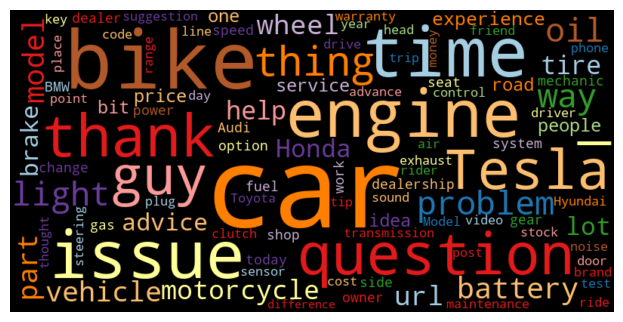

In [42]:
from blueprints.exploration import wordcloud

wordcloud(freq_df['freq'], max_words=100)

  0%|          | 0/24712 [00:00<?, ?it/s]

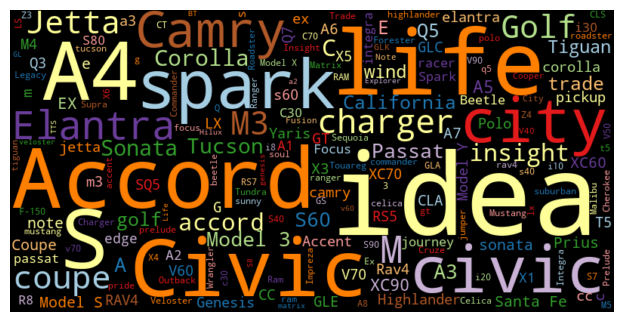

In [43]:
freq_df = count_words(df, 'models')
wordcloud(freq_df['freq'])

  0%|          | 0/24712 [00:00<?, ?it/s]

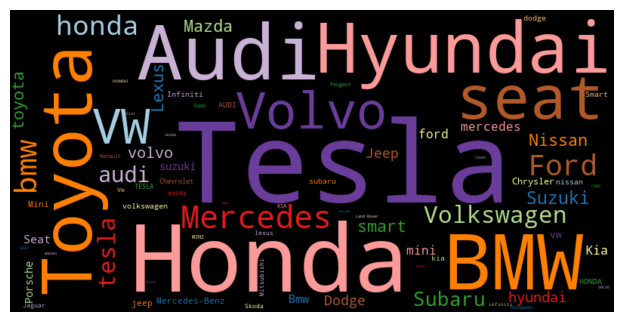

In [44]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

## Synonym Resolution

In [45]:
synonyms = { brand: brand for brand in cars.brands }
synonyms['mercedes-menz'] = 'mercedes'
synonyms['volkswagen'] = 'vw'

df['brands'] = df['brands'].progress_map(lambda brands: [synonyms[b.lower()] for b in brands])

  0%|          | 0/24712 [00:00<?, ?it/s]

  0%|          | 0/24712 [00:00<?, ?it/s]

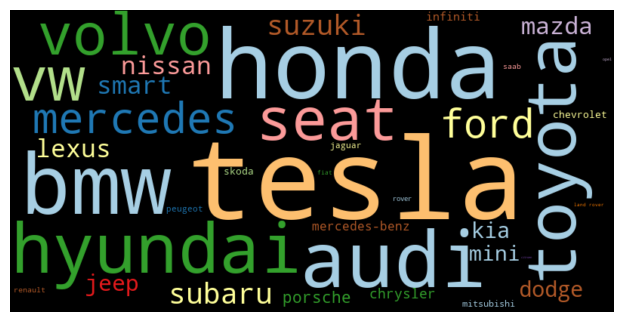

In [46]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

## Saving the Prepared Data

Alternatively into a SQL database or JSON file.

In [47]:
# convert lists of tokens into space-separated strings for csv-saving
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items).lower())

df.to_csv(f"reddit-autos-selfposts-prepared.csv", sep=";", decimal=".", index=False)

In [48]:
# restore lists
# df[nlp_columns] = df[nlp_columns].applymap(lambda items: items.split())